# Company Classifier

In [ ]:
import ast
import pickle

import pandas as pd
import matplotlib.pylab as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

from utils.preprocessing import (
    IndustryGrouper,
    TextGrouper,
    IndustrySectorGrouper,
    DescriptionSectorGrouper,
    ExtendedSectorGrouper,
    TaxonomyVectorizer
)

# NOTE dataset

companies_df = pd.read_csv("../data/companies.csv")

# initial preprocessing

companies_df["business_tags"] = companies_df["business_tags"].apply(ast.literal_eval)
companies_df["description"] = companies_df["description"].fillna("")
companies_df = companies_df[companies_df["category"].notna()].reset_index(drop=True)

# NOTE configuration variables

CLUSTERS_NUMBER = 220
TRAIN_RATIO = 0.8

## Target Feature Engineering

### Feature Constuction

To construct the target feature it is necessary to figure out the features that
the clustering model uses. This is important because the labels are infered
based on these features.

Clustering, groups data that is close toghether in the feature space. Because
of this it is mandatory to choose features that separate data well. In our case
because of the vectorization, we need a small to medium number or keywords that
place a description or tags about a company near each other in the reference
space.

At the same it is not necessary to have a large number of keywords because
the clustering is more expensive and won't separate the data well enough. There
are better embeddings than solve the problem of meaning and ordering, discussed
in the README, than TF-IDF does.

Further more, it is not known if all taxonomy classes are present in the
dataset. For this step it is assumed that every taxonomy class appears at least
once.

The considered approaches are:
* clustering based on vectorization of *sector* and *business_tags*
* clustering based on vectorization of *sector*, *category* and *niche* features
* clustering based on one-hot encoding of the *sector* feature and vectorization of *category* and *niche* features

In [ ]:
# pipelines

construct_pipelines = [
    ("all", Pipeline([
        ("grouper", TextGrouper()),
        ("col_transformer", ColumnTransformer([
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("clusterer", KMeans(CLUSTERS_NUMBER))
    ])),
    ("industry", Pipeline([
        ("grouper", IndustryGrouper()),
        ("col_transformer", ColumnTransformer([
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("clusterer", KMeans(CLUSTERS_NUMBER))
    ])),
    ("categorical", Pipeline([
        ("grouper", IndustrySectorGrouper()),
        ("col_transformer", ColumnTransformer([
            ("encoder", OneHotEncoder(), ["sector"]),
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("clusterer", KMeans(CLUSTERS_NUMBER))
    ]))
]

# training - takes about 30s

names = []
silhouette_scores = []

for name, constr_pipeline in construct_pipelines:
    constr_pipeline.fit_predict(companies_df)

    names.append(name)
    score = silhouette_score(constr_pipeline.transform(companies_df), constr_pipeline.named_steps["clusterer"].labels_)
    silhouette_scores.append(score)

# plotting

fig, ax = plt.subplots()

ax.bar(names, silhouette_scores)

plt.show()

By looking at the bar plot, the industry features have the lowest silhouette
score overall. This means that this combination of features, when vectorized,
meaning being put into a reference space, describe the clusters best.

The actual lowest value corresponds to the first preprocessing but it is
explained later why this is not a good indicator.

> Sometimes the scores can vary from iteration to iteration because of the
> nature of the **KMeans** model. But over many iterations the score of the
> industry features is always the lowest.

The reason why these features fit the data well is because the texts that
resulted from the grouping of the individual strings in each feature don't
contain many different words so the clusterer si able to separate them well in
the reference space and group them correctly.

Another reason why the industry features are a good choice is because they
contain just the right number of words to cluster the data well while not being
computationally expensive. 

In [ ]:
# NOTE construction pipeline based on bar plot

construct_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clusterer", KMeans(CLUSTERS_NUMBER))
])

### Number of taxonomy classes

There is the posibility that not all taxonomy classes apear in the original
dataset. The distribution (not really a distribution because classes are
categorical) of the taxonomy classes might not be uniform. This tells us that
maybe not all taxonomy classes are used and a clustering approach for all of
them will not work as intended.

To test this hypothesis a metric is used to determine the *K* hyperparameter that
clusters the dataset best.

An elbow plot is the most common plot to evaluate when it comes to choosing *K*.
Based on this plot, the *k* parameter that works best is chosen.

In [ ]:
# loading training scores

with open("../data/cluster_models_inertias.pkl", "rb") as f:
    points = pickle.load(f)

clusters_numbers, inertias = points

# plotting

fig, ax = plt.subplots()

ax.plot(clusters_numbers, inertias)

plt.show()

Because the elbow plot doesn't show a clear "elbow" line it is hard to interpret
the data and conclude if there is a value for K that clusters the data best.

It is also possible that the company for which we do the analysis just needs to
classify the dataset using all taxonomy classes. In that case the elbow plot
is not important anymore since all classes are required.

Because of the reasons mentioned above from now it is assumed that all taxonomy
classes are required and appear at least once in the original dataset.

In [ ]:
# NOTE number of clusters based on elbow plot

construct_pipeline.named_steps["clusterer"] = KMeans(CLUSTERS_NUMBER)

companies_df["taxonomy"] = construct_pipeline.fit_predict(companies_df)

## Training & Results

### Feature Preprocessing

A good data representation (embedding) can have significantly improve the
accuracy of the model. Because of this, models require a good preprocessing.

Training is different from feature cronstruction because if the latter requires
diverse data to compute complex relationships between features while in the
former requires clear separation of data for grouping.

Because of this the preprocessing approaches consider almost all features for
training so that the model learns to use different similar words for the same
taxonomy label.

The considered approaches are:
* classification based on vectorization of all features
* classification based on *sector*, *category* and *niche* features (should
capture the most important words and be less expensive)
* classification based on one-hot encoding of the *sector* feature and
vectorization of all other features
* classification based on one-hot encoding of the *sector* feature and
vectorization of *business_tags* and *description* and (should have the same effect but be less expensive)

In order to test multiple preprocessing approaches, logistic regression is
chosen as the initial model. Since it uses the softmax function to compute
probabilities, it represents a good starting point for analysis.

### Training

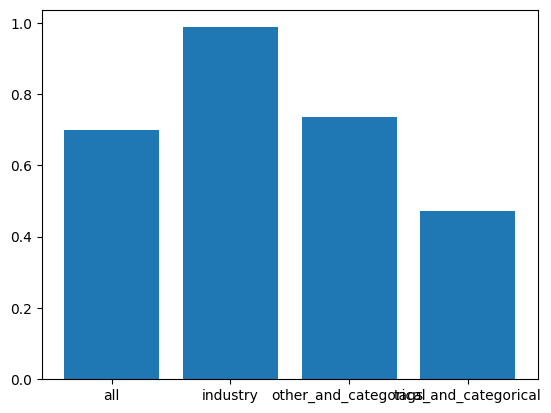

In [ ]:
# pipelines

classification_pipelines = [
    ("all", Pipeline([
        ("grouper", TextGrouper()),
        ("col_transformer", ColumnTransformer([
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("classifier", LogisticRegression())
    ])),
    ("industry", Pipeline([
        ("grouper", IndustryGrouper()),
        ("col_transformer", ColumnTransformer([
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("classifier", LogisticRegression())
    ])),
    ("other_and_categorical", Pipeline([
        ("grouper", ExtendedSectorGrouper()),
        ("col_transformer", ColumnTransformer([
            ("encoder", OneHotEncoder(), ["sector"]),
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("classifier", LogisticRegression())
    ])),
    ("tags_and_categorical", Pipeline([
        ("grouper", DescriptionSectorGrouper()),
        ("col_transformer", ColumnTransformer([
            ("encoder", OneHotEncoder(), ["sector"]),
            ("vectorizer", TfidfVectorizer(), "words")
        ])),
        ("classifier", LogisticRegression())
    ]))
]

# training - takes about 3-5min

X_train, X_test, t_train, t_test = train_test_split(companies_df.drop(["taxonomy"], axis=1), companies_df["taxonomy"], train_size=TRAIN_RATIO)

names = []
accuracy_scores = []

for name, clf_pipeline in classification_pipelines:
    clf_pipeline.fit(X_train, t_train)

    y_test = clf_pipeline.predict(X_test)

    names.append(name)
    accuracy_scores.append(accuracy_score(t_test, y_test))

# plotting

fig, ax = plt.subplots()

ax.bar(names, accuracy_scores)

plt.show()

### Training Variations

First will take a look at why the first clustering method, with the best
silhouette score, groups companies in the wrong way.

Because the vocabulary, after vectorization, contains a lot of distinct words,
the data also has high dimensionality which leads to harder grouping and a
higher computational cost and an overall higher. Because the number of features
is significantly larger than the number of lines, the model isn't able to learn
the patterns necesarry to make good predictions.

Because the vocabulary, after vectorization, contains a lot of distinct words,
the data also has high dimensionality. This leads to a higher computational cost
and an overall harder grouping. Because the number of features is significantly
larger than the number of entries int the dataset, the model isn't able to
properly learn the patterns necesarry to make good predictions.

This can be seen in the classification report.

In [ ]:
# pipelines

construct_pipeline = Pipeline([
    ("grouper", TextGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clusterer", KMeans(CLUSTERS_NUMBER))
])

classification_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clf", LogisticRegression())
])

# training - takes about 40s

companies_df["taxonomy"] = construct_pipeline.fit_predict(companies_df)

X_train, X_test, t_train, t_test = train_test_split(companies_df.drop(["taxonomy"], axis=1), companies_df["taxonomy"], train_size=TRAIN_RATIO)

classification_pipeline.fit(X_train, t_train)

y_test = classification_pipeline.predict(X_test)

# scores

print(classification_report(t_test, y_test, zero_division=0))

Another idea is represented by the posibility of using the same embedding
but pre-trained using specific words, meaning a predefined reference space. This
approach has the advantage of capturing only the words that best describe each
cluster while also reducing the feature space, which in turn reduces the
computational cost. To make sure the clustering is effective, all features are
vectorized to capture as much words as possible.

The problem with this approach arises in the training phase. Because the feature
space has small to medium dimensionality, the classification models can't learn
complex patterns that help them classify the companies better. This leads to
bad accuracy and doesn't scale well to larger datasets and datasets with higher
dimensionality (the vectorization basically filters out all words except
the ones that it has been trained with).

In [ ]:
# pipelines

construct_pipeline = Pipeline([
    ("grouper", TextGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TaxonomyVectorizer(), "words")
    ])),
    ("clusterer", KMeans(CLUSTERS_NUMBER))
])

classification_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clf", LogisticRegression())
])

# training - takes about 15s

companies_df["taxonomy"] = construct_pipeline.fit_predict(companies_df)

X_train, X_test, t_train, t_test = train_test_split(companies_df.drop(["taxonomy"], axis=1), companies_df["taxonomy"], train_size=TRAIN_RATIO)

classification_pipeline.fit(X_train, t_train)

y_test = classification_pipeline.predict(X_test)

# scores

print(classification_report(t_test, y_test, zero_division=0))


Changing the training pipeline to also use the pre-trained vectorizer while
learning using all features seems to be better.

This proves to have a better accuracy but the accuracy is misleading because in
this case the model may overfit. Because the feature space is small, and the
words are repetitive, the model tends to memorize the dataset instead of
learning relationships between features.  to  doesn't scale well to larger
dataset because it takes and can't learn complex patterns

This also doesn't scale well to larger datasets and dataset with more features
because it can't learn complex patterns due to the fixed vectorization used.

In [ ]:
# pipelines

construct_pipeline = Pipeline([
    ("grouper", TextGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TaxonomyVectorizer(), "words")
    ])),
    ("clusterer", KMeans(CLUSTERS_NUMBER))
])

classification_pipeline = Pipeline([
    ("grouper", TextGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TaxonomyVectorizer(), "words")
    ])),
    ("clf", LogisticRegression())
])

# training - takes about 15s

companies_df["taxonomy"] = construct_pipeline.fit_predict(companies_df)

X_train, X_test, t_train, t_test = train_test_split(companies_df.drop(["taxonomy"], axis=1), companies_df["taxonomy"], train_size=TRAIN_RATIO)

classification_pipeline.fit(X_train, t_train)

y_test = classification_pipeline.predict(X_test)

# scores

print(classification_report(t_test, y_test, zero_division=0))

Another aspect is trying to see if all taxonomy classes are used in the
original dataset.

In theory, if the entries are placed well enough in the feature space, the exact
number of cluster, and therefore taxonomy classes, can be found using DBSCAN.
The only problem to this approach is the *epsilon* hyperpatameter which may, or
may not be hard to find.

In this example the model has a pretty high accuracy but the value is a wrong
indicator because it classifies the majority of the companies using the same
taxonomy class which is not correct.

In [ ]:
# pipelines

construct_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clusterer", DBSCAN(1))
])

classification_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
        ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clf", LogisticRegression())
])

# training - takes about 15s

companies_df["taxonomy"] = construct_pipeline.fit_predict(companies_df)

X_train, X_test, t_train, t_test = train_test_split(companies_df.drop(["taxonomy"], axis=1), companies_df["taxonomy"], train_size=TRAIN_RATIO)

classification_pipeline.fit(X_train, t_train)

y_test = classification_pipeline.predict(X_test)

# scores

print(classification_report(t_test, y_test, zero_division=0))

### Conclusion

Based on the observations made, the TF-IDF vectorization of the concatenation
of the *sector*, *category* and *niche* features provides a solid "reference"
space for grouping companies and training models to efficiently classify these
companies while also maintaining a low computational cost which is a necessity
when scaling models for larger datasets.

In [ ]:
# NOTE final construction and classification pipelines

construct_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
            ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clusterer", KMeans(CLUSTERS_NUMBER))
])

classification_pipeline = Pipeline([
    ("grouper", IndustryGrouper()),
    ("col_transformer", ColumnTransformer([
            ("vectorizer", TfidfVectorizer(), "words")
    ])),
    ("clf", LogisticRegression())
])

# training - takes about 15s

companies_df["taxonomy"] = construct_pipeline.fit_predict(companies_df)

X_train, X_test, t_train, t_test = train_test_split(companies_df.drop(["taxonomy"], axis=1), companies_df["taxonomy"], train_size=TRAIN_RATIO)

classification_pipeline.fit(X_train, t_train)

y_test = classification_pipeline.predict(X_test)

# scores

print(classification_report(t_test, y_test, zero_division=0))